In [1]:
#export
from exp.nb_00 import *
import operator

def test(a,b,cmp,cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a,b),f"{cname}:\n{a}\n{b}"

def test_eq(a,b): test(a,b,operator.eq,'==')



In [2]:
test_eq(TEST,'test')

## Get Data 

In [3]:
#export
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import FloatTensor as tensor

MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz'



In [4]:
import pandas as pd 

In [7]:
#export
import pandas as pd 
from mnist import MNIST
def get_minst():
    mndata = MNIST('/home/vimarshc/Documents/data/mnist')

    x_train, y_train = mndata.load_training()
    x_test, y_test = mndata.load_testing()    
    return x_train, y_train,x_test, y_test

In [8]:
x_train, y_train,x_test, y_test = get_minst()

In [9]:
x_train, y_train,x_test, y_test = map(tensor,(x_train, y_train,x_test, y_test))

In [10]:
x_train, x_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([60000, 784]),
 tensor([5., 0., 4.,  ..., 5., 6., 8.]),
 torch.Size([60000]),
 tensor(0.),
 tensor(9.))

In [11]:
x_test.shape

torch.Size([10000, 784])

In [12]:
n,c = x_train.shape
assert n==y_train.shape[0]==60000
test_eq(c,28*28)
test_eq(y_train.min(),0)
test_eq(y_train.max(),9)

In [13]:
mpl.rcParams['image.cmap'] = 'gray'

tensor(0.)


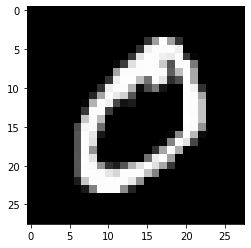

In [15]:
img = x_train[1]
print(y_train[1])
plt.imshow(img.view((28,28)))

## Initial Model 

In [16]:
weights = torch.randn(784,10)
bias = torch.zeros(10)

In [17]:
weights.shape

torch.Size([784, 10])

##### Matrix Mul

In [18]:
# worse 
def matmul(a,b):
    ar,ac = a.shape # n_rows * n_cols
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac): # or br
                c[i,j] += a[i,k] * b[k,j]
    return c


In [19]:
m1 = x_test[:5]
m2 = weights
m1.shape,m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [20]:
%time t1=matmul(m1, m2)

CPU times: user 573 ms, sys: 3.84 ms, total: 577 ms
Wall time: 574 ms


In [21]:
t1.shape

torch.Size([5, 10])

### Elementwise MatMul 

In [22]:
def matmul(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar): 
        for j in range(bc):
            # Any trailing ",:" can be removed
            c[i,j] = (a[i,:] * b[:,j]).sum()
    return c


In [23]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [24]:
%time t1=matmul(m1, m2)

CPU times: user 7.14 ms, sys: 222 µs, total: 7.36 ms
Wall time: 5.63 ms


In [25]:
#export
def near(a,b): return torch.allclose(a, b, rtol=1e-3, atol=1e-5)
def test_near(a,b): test(a,b,near)

In [26]:
t1 == matmul(m1,m2)

tensor([[True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True]])

In [27]:
test_near(t1,matmul(m1, m2))

### BroadCasting 

In [28]:
def matmul(a,b):
    ar,ac = a.shape
    br,bc = b.shape
    assert ac==br
    c = torch.zeros(ar, bc)
    for i in range(ar):
#       c[i,j] = (a[i,:]          * b[:,j]).sum() # previous
        c[i]   = (a[i  ].unsqueeze(-1) * b).sum(dim=0)
#       c[i]   = (a[i,None ] * b).sum(dim=0)
    return c

In [29]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [30]:
print(m1[0].shape)
print(m1[0].unsqueeze(-1).shape)
print(m2.shape)

torch.Size([784])
torch.Size([784, 1])
torch.Size([784, 10])


In [31]:
m1[0].unsqueeze(-1).expand_as(m2).shape
# |
# |
# m1[i] * n
# |
# |

torch.Size([784, 10])

In [32]:
(m1[0  ].unsqueeze(-1) * m2).sum(dim=1).shape

torch.Size([784])

In [33]:
%timeit -n 10 _=matmul(m1, m2)

419 µs ± 99.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [34]:
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [35]:
# Final Solution 
%timeit -n 10 t2 = m1.matmul(m2)

The slowest run took 76.67 times longer than the fastest. This could mean that an intermediate result is being cached.
105 µs ± 234 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [36]:
%timeit -n 10 t2 = m1@m2

The slowest run took 10.64 times longer than the fastest. This could mean that an intermediate result is being cached.
31.8 µs ± 40.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [38]:
!python notebook2script.py 01_matmul.ipynb

Converted 01_matmul.ipynb to exp/nb_01.py
